In [1]:
import torch

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


# Data

In [3]:
# import os
import pickle
raw_file = './../../data/dump/mimic.pickle'
with open(raw_file, 'rb') as handle:
    data = pickle.load(handle)

In [4]:
print(type(data))
print(type(data[0]))
print(data[0].keys())

<class 'list'>
<class 'dict'>
dict_keys([0, 1, 2])


In [5]:
import matplotlib.pyplot as plt

(array([1.473e+03, 7.100e+01, 2.600e+01, 5.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([ 3. ,  6.4,  9.8, 13.2, 16.6, 20. , 23.4, 26.8, 30.2, 33.6, 37. ]),
 <a list of 10 Patch objects>)

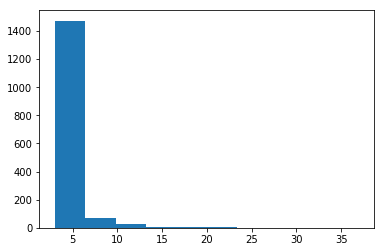

In [6]:
plt.hist(list(map(len, data)))

In [7]:
# [i for i in data[0].values()]

## Convert to dataframe

In [8]:
import pandas
import numpy as np

In [9]:
def gender_to_categorical(x):
    return 0 if x=='M' else 1

def mimic_correct_datatypes(icu_df):

    # TIMES
    icu_df['ADMITTIME'] = icu_df['ADMITTIME'].astype('datetime64')
    icu_df['DEATHTIME'] = icu_df['DEATHTIME'].astype('datetime64')
    icu_df['DISCHTIME'] = icu_df['DISCHTIME'].astype('datetime64')
    icu_df['INTIME'] = icu_df['INTIME'].astype('datetime64')
    icu_df['OUTTIME'] = icu_df['OUTTIME'].astype('datetime64')
    icu_df['DOB'] = icu_df['DOB'].astype('datetime64')

    # FLOATS
    icu_df['AGE'] = icu_df['AGE'].astype('float32')
    icu_df['LOS'] = icu_df['LOS'].astype('float32')

    # INTS
    icu_df['SUBJECT_ID'] = icu_df['SUBJECT_ID'].astype('int')
    icu_df['HADM_ID'] = icu_df['HADM_ID'].astype('int')
    icu_df['ICUSTAY_ID'] = icu_df['ICUSTAY_ID'].astype('int')
    icu_df['MORTALITY'] = icu_df['MORTALITY'].astype('int')
    return icu_df

In [10]:
def mimic_data_to_df(data, colnames=None):
    flat_data = [icu_visit for data_i in data for icu_visit in data_i.values()]
    icu_df = pandas.DataFrame(flat_data)
    icu_df = mimic_correct_datatypes(icu_df)
    # Make gender a 0/1 variable
    icu_df['GENDER'] = icu_df['GENDER'].apply(gender_to_categorical)
    
    # Make ETHNICITY a one-hot feature set, removing the first column to ensure there is no linear dependence
#     ethnicity_dummies = pandas.get_dummies(icu_df.ETHNICITY, drop_first=True, prefix='ETHNICITY_')
#     icu_df = pandas.concat([icu_df.drop('ETHNICITY', axis=1), ethnicity_dummies], axis=1)
    
    # Center the AGE column
#     icu_df['AGE'] = (icu_df.AGE - icu_df.AGE.mean()) / icu_df.AGE.std()
    
    if colnames is None:
        return icu_df
    else:
        return icu_df[colnames]

## Datatypes

In [11]:
def mimic_data_tensors(data=None):
    if data==None:
        raw_file = './../data/dump/mimic.pickle'
        with open(raw_file, 'rb') as handle:
            data = pickle.load(handle)

    admit_times, lengths = compute_admit_times(data)
    mask = create_mask(lengths)
    # This is necessary because of the way in which intervals are created,
    # the last interval value is the -ve of the last time value, and
    # occurs at the time t_{i+1}
    admit_times = admit_times*mask
    markers = compute_markers(data)
    data_dict = {
        't': admit_times,
        'x': markers
    }
    return data_dict, mask

In [12]:
mimic_data, mask = mimic_data_tensors(data)

NameError: name 'compute_admit_times' is not defined

In [ ]:
icu_df = mimic_data_to_df(data)

In [ ]:
mimic_data['t'][:6,0]

In [ ]:
def create_mask(lengths):
    """
        Input:
            lengths: list of size N=num_samples
            
        Return:
            mask: tensor of shape T_max x N x 1
    """
    # Convert lengths to a row vector
    length_max = max(lengths)
    num_samples = len(lengths)
    lengths = torch.tensor(lengths, device=device).view(1,-1)
    
    mask = (torch.arange(length_max, device=device).view(-1,1).repeat(1,num_samples) < lengths).float()
    mask = mask.view(*mask.shape,1)
    return mask

In [ ]:
icu_df = mimic_data_to_df(data)

In [ ]:
icu_df.columns

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

In [14]:
def compute_markers(data):
    """
        Input: 
            data: list of dicts, where each dict corresponds to a patient and has 1 entry per icu visit
        Output:
            admit_times: list of length num_data_train, each element is numpy array of shape T_i x marker_dim
    """
    markers = []
    icu_df = mimic_data_to_df(data)
    
    
    # Restricting the icd9 codes to those
    # which have occurrence frequency of more than 80 (= 217 / 3126 codes)
    _mlb = MultiLabelBinarizer()
    _markers = _mlb.fit_transform(icu_df.ICD9_CODE)
    codes_subset = _mlb.classes_[(_markers.sum(0) > 80)]
    # Use code_subset to select only the high freq icd9 codes
    # This WILL throw a warning (because we're skipping many codes) but that's okay
    mlb = MultiLabelBinarizer(codes_subset)
    markers_multilabel = mlb.fit_transform(icu_df.ICD9_CODE)
    
    group_patients = icu_df.groupby('SUBJECT_ID')
    for patient_idx, patient_df_rows in group_patients.groups.items():
        # Get an array of shape  (T_i x marker_dim)
        patient_markers = markers_multilabel[patient_df_rows]
        t_i, marker_dim = patient_markers.shape
        markers.append(patient_markers)
    return markers

In [15]:
cd ..

/home/abhishekshar/hierarchichal_point_process/src


In [16]:
from utils.synthetic_data import get_intervals

In [17]:
cd notebooks/

/home/abhishekshar/hierarchichal_point_process/src/notebooks


In [36]:
def compute_times(data):
    """
        Input: 
            data: list of dicts, where each dict corresponds to a patient and has 1 entry per icu visit
        Output:
            t_data: list of length num_data_train, each element is numpy array of shape T_i x 3
    """
#     max_visit_n = max([len(data_i) for data_i in data])
    t_data = []
    icu_df = mimic_data_to_df(data)
    
    group_patients = icu_df.groupby('SUBJECT_ID')
    for patient_idx, patient_df_rows in group_patients.groups.items():
        t_data_i = icu_df.iloc[patient_df_rows][['ADMITTIME', 'INTIME', 'OUTTIME']]
        admit_times = t_data_i.ADMITTIME
        visit_durations = t_data_i.OUTTIME - t_data_i.INTIME
        
        # Compute the intervals
        shifted = np.concatenate([np.zeros_like(admit_times[0:1]), admit_times[:-1]], axis=0)
        intervals = admit_times - shifted

        t_data_i = np.stack([admit_times.values.astype(int),
                           visit_durations.values.astype(int),
                           intervals.values.astype(int)]).T
        t_data.append(t_data_i)
    return t_data

In [37]:
t_data = compute_times(data)

In [23]:
x_data = compute_markers(data)

/home/abhishekshar/dmm/env-hrmtpp/lib/python3.6/site-packages/sklearn/preprocessing/label.py:935: UserWarning: unknown class(es) ['0051', '0074', '0085', '00869', '0088', '0090', '0091', '0092', '0093', '01085', '01190', '01194', '01325', '01803', '01880', '01894', '01896', '0270', '0272', '0310', '0312', '0319', '0340', '0380', '03810', '03812', '03819', '0382', '0383', '03840', '03843', '03844', '0388', '0391', '0400', '04100', '04101', '04102', '04103', '04109', '04110', '04112', '04119', '0412', '04149', '0415', '0416', '04182', '04183', '04184', '04185', '04186', '04189', '0419', '0479', '0529', '05311', '05312', '05319', '05320', '05371', '0539', '05410', '0542', '0543', '05443', '05479', '0549', '0578', '0701', '07020', '07022', '07030', '07031', '07041', '07044', '07051', '07071', '0709', '075', '07819', '0785', '0794', '07951', '07953', '0796', '07989', '07999', '0860', '08881', '0940', '1100', '1101', '1103', '1104', '1105', '1108', '1109', '1118', '1121', '1122', '1123', '11

In [130]:
print(len(t_data))
print(t_data[0].shape)
print(t_data[0])

1585
(3, 3)
[[5090973300000000000 5092055340000000000 5186547000000000000]
 [     95869000000000     592665000000000     375693000000000]
 [5090973300000000000    1082040000000000   94491660000000000]]
